In [1]:
import sys
sys.path.append("../..")

# Noisy Pendulum - Iterated Posterior Linearization Filter and Smoother Examples

Estimate pendulum state with IPLF and IPLS as in Examples 10.13 and 14.23 of the book

_Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed., Cambridge University Press._

See LICENSE provided with the software.

## Imports

### Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import tqdm
import json

### Helpers imports

In [3]:
from python.common_utilities import generate_pendulum, RandomState, rmse, plot_pendulum

## Routine

Set the parameters:

In [4]:
dt = 0.01
g  = 9.81

In [5]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                      [dt ** 2 / 2, dt]])
R  = 0.1 * np.eye(1)

In [6]:
x_0 = np.array([1.5, 0.])

## Load or simulate data

In [7]:
# Simulation
#random_state = RandomState(1)
#steps = 500
#timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)

# This loads stored data from file
with open("pendulum.json") as fp:
    jsondata = json.load(fp)
    timeline = np.array(jsondata["T"])
    states = np.array(jsondata["X"]).T
    observations = np.array(jsondata["Y"])
    steps = states.shape[0]

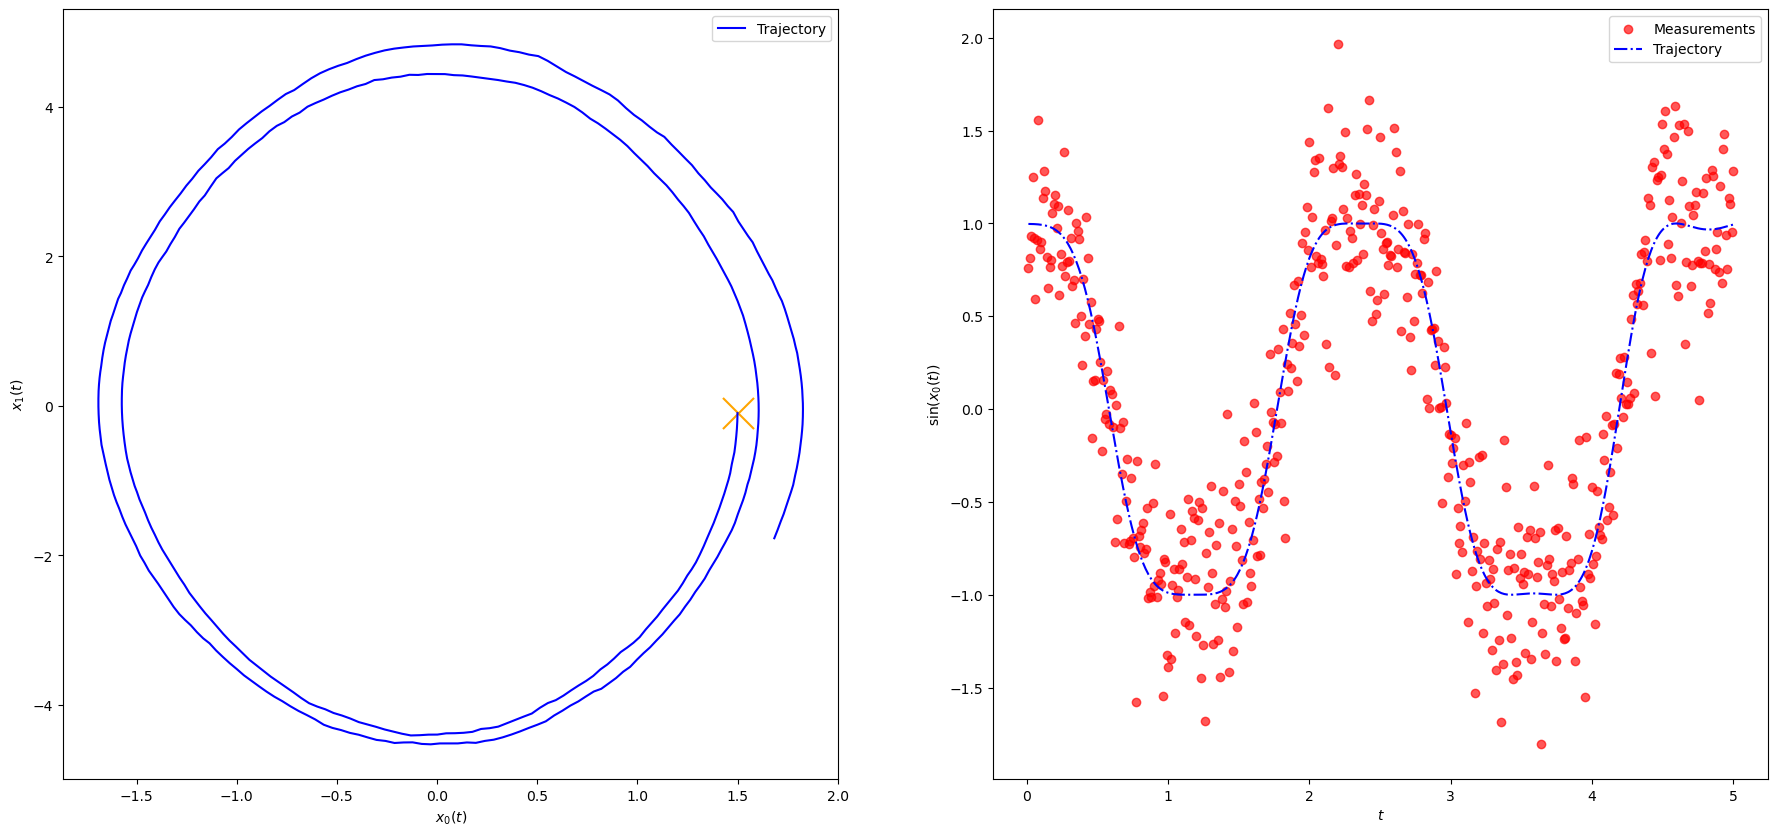

In [8]:
plot_pendulum(timeline, observations, states, "Trajectory")

## Iterated Posterior Linearization Filter

In [9]:
#m_0 = np.array([1.6, 0.])  # Slightly off
#P_0 = np.array([[0.1, 0.], 
#                [0., 0.1]])
m_0 = np.array([0.0, 0.0])
P_0 = np.eye(2)

In [10]:
from itertools import product
from numpy.polynomial.hermite_e import hermegauss

def iterated_posterior_linearization_filter(m_0, P_0, g, Q, dt, R, observations, niter=10, order=3):
    n = m_0.shape[-1]
    steps = observations.shape[0]

    # Gauss-Hermite sigma points
    unit_sigma_points, hermite_weights = hermegauss(order)  # 1D points
    hermite_weights = hermite_weights / hermite_weights.sum()

    # n-D points
    unit_sigma_points = np.array(list(product(*(unit_sigma_points for _ in range(n))))).T  # Cartesian product
    hermite_weights = np.array(list(product(*(hermite_weights for _ in range(n))))).prod(axis=1)
    
    iplf_m = np.empty((steps, n))
    iplf_P = np.empty((steps, n, n))
    
    m = m_0[:]
    P = P_0[:]
    
    for i in range(steps):
        y = observations[i]
        
        # Compute the sigma points for the dynamics
        L = np.linalg.cholesky(P)
        sigma_points = L @ unit_sigma_points + m.reshape(-1, 1)
        
        # Progagate through the dynamics
        sigma_points[0, :], sigma_points[1, :] = sigma_points[0, :] + dt * sigma_points[1, :], sigma_points[1, :] - g * dt * np.sin(sigma_points[0, :])        
        
        # Predicted state distribution
        m = np.dot(sigma_points, hermite_weights)
        P = np.dot(hermite_weights.reshape(1, -1) * (sigma_points - m.reshape(-1, 1)), (sigma_points - m.reshape(-1, 1)).T) + Q
        
        mp = m
        Pp = P
        for iter in range(niter):
            # Compute the sigma points for the observation
            L = np.linalg.cholesky(P)
            sigma_points = L @ unit_sigma_points + m.reshape(-1, 1)

            # Progagate through the measurement model
            sigma_observations = np.sin(sigma_points[0, :])

            # sigma points measurement mean and covariance
            predicted_mu = np.dot(sigma_observations, hermite_weights)
            predicted_cov = np.dot(hermite_weights * (sigma_observations - predicted_mu), sigma_observations - predicted_mu) + R
            cross_cov = np.dot(sigma_points - m.reshape(-1, 1), hermite_weights * (sigma_observations - predicted_mu))

            # Linearization
            H = linalg.solve(P, cross_cov[:, np.newaxis], assume_a="pos").T
            b = predicted_mu - H.dot(m)
            O = predicted_cov - H @ P @ H.T
            
            # Affine Kalman filter update
            v = y - H.dot(mp) - b
            S = H.dot(Pp.dot(H.T)) + O
            K = linalg.solve(S, H @ Pp, assume_a="pos").T 
            m = mp + K @ np.atleast_1d(v)
            P = Pp - K @ S @ K.T
            P = 0.5 * (P + P.T)
        
        iplf_m[i] = m
        iplf_P[i] = P
    return iplf_m, iplf_P

In [11]:
iplf_m, iplf_P = iterated_posterior_linearization_filter(m_0, P_0, g, Q, dt, R, observations)

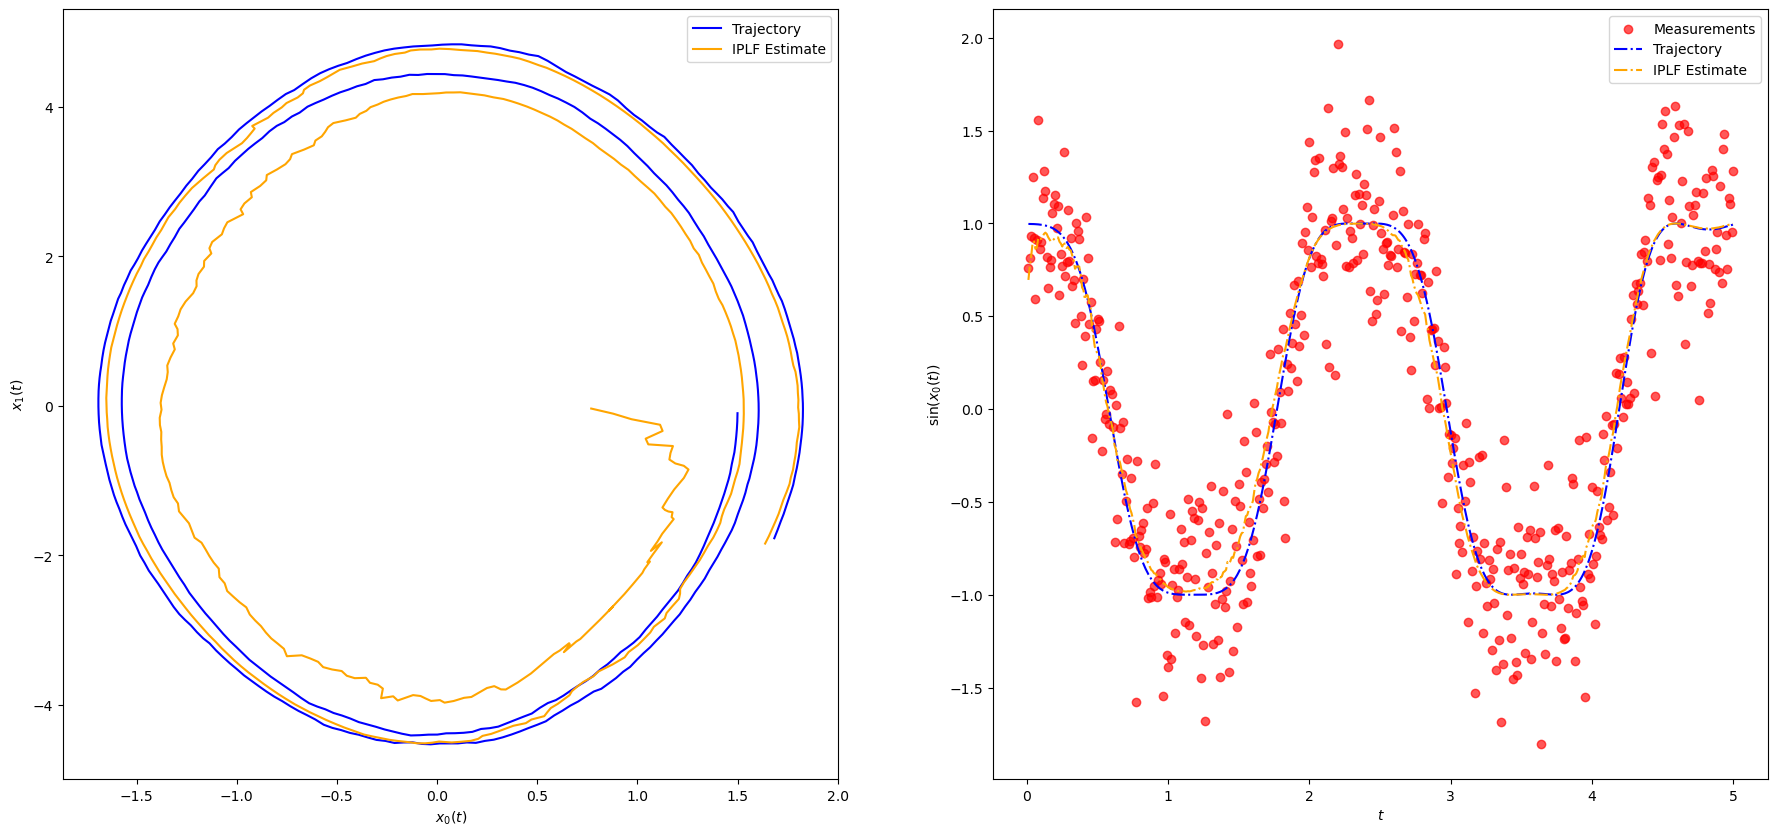

In [12]:
plot_pendulum(timeline, observations, states, "Trajectory", iplf_m, "IPLF Estimate")

In [13]:
rmse_iplf = rmse(iplf_m[:, :1], states[:, :1])
print(f"IPLF RMSE: {rmse_iplf}")

IPLF RMSE: 0.14055766458714145


## Iterated Posterior Linearization Smoother

In [14]:
def iterated_posterior_linearization_smoother(init_m, init_P, m_0, P_0, g, Q, dt, R, observations, niter=10, order=3):    
    n = m_0.shape[-1]
    steps = observations.shape[0]
    
    # Gauss-Hermite sigma points
    unit_sigma_points, hermite_weights = hermegauss(order)  # 1D points
    hermite_weights = hermite_weights / hermite_weights.sum()

    # n-D points
    unit_sigma_points = np.array(list(product(*(unit_sigma_points for _ in range(n))))).T  # Cartesian product
    hermite_weights = np.array(list(product(*(hermite_weights for _ in range(n))))).prod(axis=1)
        
    plf_m = np.empty((steps, n))
    plf_P = np.empty((steps, n, n))

    ipls_m = np.empty((steps, n))
    ipls_P = np.empty((steps, n, n))
    
    cs = np.empty((steps, n))
    As = np.empty((steps, n, n))
    Ls = np.empty((steps, n, n))

    ny = 1
    bs = np.empty((steps, ny))
    Hs = np.empty((steps, ny, n))
    Os = np.empty((steps, ny, ny))
    
    nom_m = np.copy(init_m)
    nom_m_0 = m_0
    nom_P = np.copy(init_P)
    nom_P_0 = P_0

    for iter in range(niter):
        # Linearize all dynamic models
        for i in range(steps):
            if i == 0:
                m = nom_m_0
                P = nom_P_0
            else:
                m = nom_m[i-1]
                P = nom_P[i-1]
                
            # Compute the sigma points for the dynamics
            L = np.linalg.cholesky(P)
            sigma_points = L @ unit_sigma_points + m.reshape(-1, 1)

            # Progagate through the dynamics
            pred_sigma_points = np.empty(sigma_points.shape)
            pred_sigma_points[0, :], pred_sigma_points[1, :] = sigma_points[0, :] + dt * sigma_points[1, :], sigma_points[1, :] - g * dt * np.sin(sigma_points[0, :])        

            # Predicted state distribution
            mum = np.dot(pred_sigma_points, hermite_weights)
            Px = np.dot(hermite_weights.reshape(1, -1) * (pred_sigma_points - mum.reshape(-1, 1)), (pred_sigma_points - mum.reshape(-1, 1)).T) + Q
            Pxx = np.dot(hermite_weights.reshape(1, -1) * (sigma_points - m.reshape(-1, 1)), (pred_sigma_points - mum.reshape(-1, 1)).T)
                
            A = linalg.solve(P, Pxx, assume_a="pos").T
            c = mum - A.dot(m)
            L = Px - A @ P @ A.T
            
            As[i] = A
            cs[i] = c
            Ls[i] = L
            
        # Linearize all measurement models
        for i in range(steps):
            m = nom_m[i]
            P = nom_P[i]
        
            # Compute the sigma points for the observation
            L = np.linalg.cholesky(P)
            sigma_points = L @ unit_sigma_points + m.reshape(-1, 1)

            # Progagate through the measurement model
            sigma_observations = np.sin(sigma_points[0, :])

            # sigma points measurement mean and covariance
            predicted_mu = np.dot(sigma_observations, hermite_weights)
            predicted_cov = np.dot(hermite_weights * (sigma_observations - predicted_mu), sigma_observations - predicted_mu) + R
            cross_cov = np.dot(sigma_points - m.reshape(-1, 1), hermite_weights * (sigma_observations - predicted_mu))

            # Linearization
            H = linalg.solve(P, cross_cov[:, np.newaxis], assume_a="pos").T
            b = predicted_mu - H.dot(m)
            O = predicted_cov - H @ P @ H.T
            
            Hs[i] = H
            bs[i] = b
            Os[i] = O

            
        # Run affine Kalman filter
        m = m_0
        P = P_0
        for i in range(steps):
            y = observations[i]
            
            A = As[i]
            c = cs[i]
            L = Ls[i]

            m = A @ m + c
            P = A @ P @ A.T + L

            H = Hs[i]
            b = bs[i]
            O = Os[i]

            v = y - H.dot(m) - b
            S = H.dot(P.dot(H.T)) + O
            K = linalg.solve(S, H @ P, assume_a="pos").T 
            m = m + K @ np.atleast_1d(v)
            P = P - K @ S @ K.T
            P = 0.5 * (P + P.T)
            
            plf_m[i] = m
            plf_P[i] = P
            
        # Run smoother
        ms = plf_m[-1]
        Ps = plf_P[-1]
    
        ipls_m[-1] = ms
        ipls_P[-1] = Ps
        nom_m[-1] = ms
        nom_P[-1] = Ps
    
        for i in range(steps-2, -2, -1):
            if i == -1:
                m = m_0
                P = P_0
            else:
                m = plf_m[i]
                P = plf_P[i]

            A = As[i+1]
            c = cs[i+1]
            L = Ls[i+1]
            
            mp = A @ m + c
            Pp = A @ P @ A.T + L
            Gk = linalg.solve(Pp, A @ P, assume_a="pos").T 

            ms = m + Gk @ (ms - mp)
            Ps = P + Gk @ (Ps - Pp) @ Gk.T
            Ps = 0.5 * (Ps + Ps.T)
        
            if i == -1:
                nom_m_0 = ms
                nom_P_0 = Ps
            else:
                ipls_m[i] = ms
                ipls_P[i] = Ps
                nom_m[i] = ms
                nom_P[i] = Ps

    return ipls_m, ipls_P


In [15]:
ipls_m, ipls_P = iterated_posterior_linearization_smoother(iplf_m, iplf_P, m_0, P_0, g, Q, dt, R, observations)

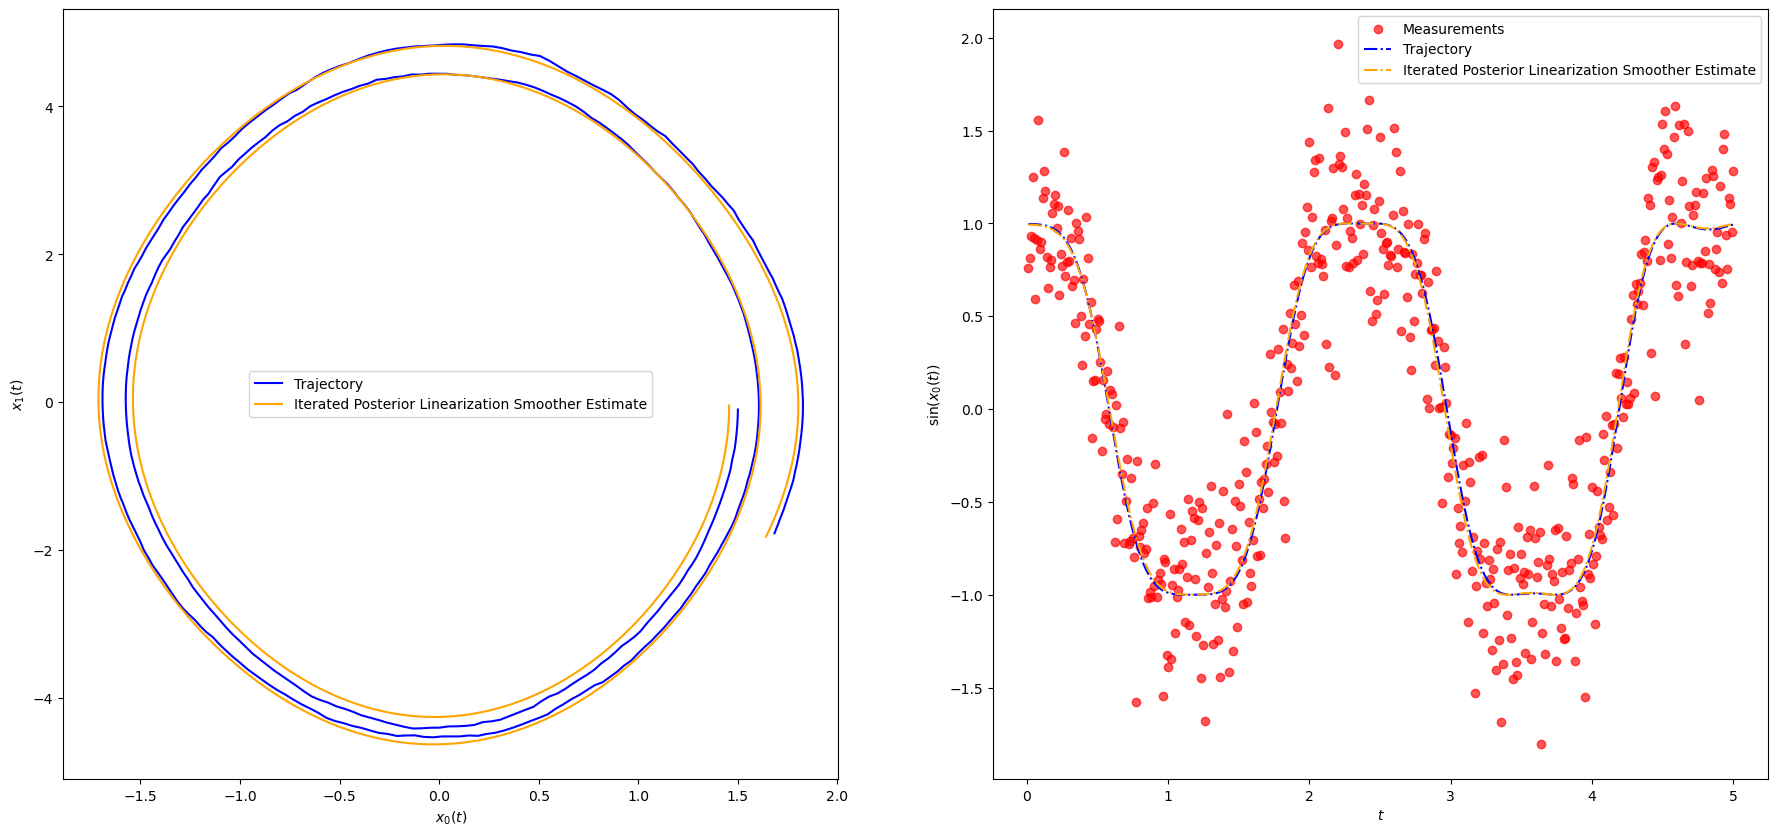

In [16]:
plot_pendulum(timeline, observations, states, "Trajectory", ipls_m, "Iterated Posterior Linearization Smoother Estimate")

In [17]:
rmse_ipls = rmse(ipls_m[:, :1], states[:, :1])
print(f"IPLS RMSE: {rmse_ipls}")

IPLS RMSE: 0.034733224044175594
